In [127]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.stats as s
import astropy.units as u
import astropy.constants as c
import astropy.visualization.wcsaxes as v
import scipy.interpolate as interp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import matplotlib.offsetbox
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from reproject import reproject_interp
import pandas as pd
import astropy.coordinates as coord
from scipy.stats import norm
import matplotlib.gridspec as gridspec
from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clip
from photutils.aperture import SkyCircularAperture, CircularAperture, ApertureStats


from spectral_cube import SpectralCube
from radio_beam import beam
from regions import Regions
from scipy import optimize


plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
        'font.size': 12,                # Set default font size
    'axes.titlesize': 14,           # Title font size
    'axes.labelsize': 12,           # X and Y label font size
    'xtick.labelsize': 10,          # X tick label font size
    'ytick.labelsize': 10,          # Y tick label font size
    'legend.fontsize': 10,          # Legend font size
})

In [128]:
#make sure you drop degenerate axes in M0 maps using carta
source_name='Oph_12'
# source_name='Oph_26'
# source_name='Oph_27'
# source_name='Oph_29'
# source_name='Oph_31'
# source_name='Oph_34'
# source_name='Oph_39'

path = '/net/vdesk/data2/bach1/ballieux/master_project_2/data/low_mass_data/'+source_name+'/' # Path to the data
B3_red_name='M0_maps/CO10_M0_red'      #M0 map of the CO 1-0 line, band 3, redshifted
B6_red_name = 'M0_maps/CO21_M0_red'    #M0 map of the CO 2-1 line, band 6, redshifted
B7_red_name = 'M0_maps/CO32_M0_red'    #M0 map of the CO 3-2 line, band 7, redshifted
B3_blue_name='M0_maps/CO10_M0_blue'    #M0 map of the CO1-0 line, band 3, blueshifted
B6_blue_name = 'M0_maps/CO21_M0_blue'    #M0 map of the CO 2-1 line, band 6, blueshifted
B7_blue_name = 'M0_maps/CO32_M0_blue'    #M0 map of the CO 3-2 line, band 7, blueshifted

if source_name == 'Oph_12':
    red_velrange='5.1;10.5'
    blue_velrange = '-3.2;1.9'
if source_name == 'Oph_26':
    red_velrange='4.3;11.8'
    blue_velrange = '-6.3;1.9'
if source_name == 'Oph_27':
    red_velrange='5.9;11'
    blue_velrange = '-10;1.0'
if source_name == 'Oph_29':
    red_velrange='5;8'
    blue_velrange = '-6;1.25'
if source_name == 'Oph_31':
    red_velrange='4.5;9'
    blue_velrange = '-1;1'
if source_name == 'Oph_34':
    red_velrange='3;7'
    blue_velrange = '-9;0.9'
if source_name == 'Oph_39':
    red_velrange='4.5;11'
    blue_velrange = '-5;2.4'

d = 140 * u.pc
e_d = 4 * u.pc

 
#Open the fits files
hdu_B3_red = fits.open(path+B3_red_name)
hdu_B6_red = fits.open(path+B6_red_name)
hdu_B7_red = fits.open(path+B7_red_name)
hdu_B3_blue = fits.open(path+B3_blue_name)
hdu_B6_blue = fits.open(path+B6_blue_name)
hdu_B7_blue = fits.open(path+B7_blue_name)

# Always manually check the beam is exactly the same for both maps, and check unit of major axis. They should be the same but check
beam_major = hdu_B7_red[0].header['BMAJ']*3600 *u.arcsec # Beam major axis size in arcseconds
beam_minor = hdu_B7_blue[0].header['BMIN']*3600 *u.arcsec # Beam minor axis size in arcseconds
beam_pa = hdu_B7_red[0].header['BPA']*u.deg  # Beam position angle in degrees


#get the pixel size form the header
if (source_name == 'Oph_12') or (source_name == 'Oph_26') or (source_name == 'Oph_27') or (source_name == 'Oph_29') or (source_name == 'Oph_31') or (source_name == 'Oph_39'):
    pixel_size=0.49 *u.arcsec #From CO32
if source_name == 'Oph_34':
    pixel_size=0.34 *u.arcsec #From CO10

#The WCS object is used to convert between pixel and world coordinates
wcs_B3_red = WCS(hdu_B3_red[0].header)
wcs_B6_red = WCS(hdu_B6_red[0].header)
wcs_B7_red = WCS(hdu_B7_red[0].header)
wcs_B3_blue = WCS(hdu_B3_blue[0].header)
wcs_B6_blue = WCS(hdu_B6_blue[0].header)
wcs_B7_blue = WCS(hdu_B7_blue[0].header)

#Two of the images needs to be regridded, this can be done because both are well sampled
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_27' or source_name == 'Oph_29' or source_name == 'Oph_31' or source_name == 'Oph_39':
    B7_red = hdu_B7_red[0].data *u.Jy*u.km/u.s
    B3_red, footprint_red_3 = reproject_interp(hdu_B3_red[0], hdu_B7_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B6_red, footprint_red_6 = reproject_interp(hdu_B6_red[0], hdu_B7_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B7_blue = hdu_B7_blue[0].data *u.Jy*u.km/u.s
    B3_blue, footprint_blue_3 = reproject_interp(hdu_B3_blue[0], hdu_B7_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B6_blue, footprint_blue_6 = reproject_interp(hdu_B6_blue[0], hdu_B7_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32

if source_name == 'Oph_34': #This is the different one!
    B3_red = hdu_B3_red[0].data *u.Jy*u.km/u.s
    B6_red, footprint_red_6 = reproject_interp(hdu_B6_red[0], hdu_B3_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B7_red, footprint_red_7 = reproject_interp(hdu_B7_red[0], hdu_B3_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B3_blue = hdu_B3_blue[0].data *u.Jy*u.km/u.s
    B6_blue, footprint_blue_6 = reproject_interp(hdu_B6_blue[0], hdu_B3_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B7_blue, footprint_blue_7 = reproject_interp(hdu_B7_blue[0], hdu_B3_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32

#RMS calculation
B3_red_rms_name = B3_red_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 3, shape does not matter
B6_red_rms_name = B6_red_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_red_rms_name = B7_red_name+'_rms'   #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter
B3_blue_rms_name = B3_blue_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 3, shape does not matter
B6_blue_rms_name = B6_blue_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_blue_rms_name = B7_blue_name+'_rms'   #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter

# #This is now just an empty region of the map to get rms level. Later convolve with 10%
hdu_B3_red_err = fits.open(path+B3_red_rms_name)
hdu_B6_red_err = fits.open(path+B6_red_rms_name)
hdu_B7_red_err = fits.open(path+B7_red_rms_name)
hdu_B3_blue_err = fits.open(path+B3_blue_rms_name)
hdu_B6_blue_err = fits.open(path+B6_blue_rms_name)
hdu_B7_blue_err = fits.open(path+B7_blue_rms_name)

#Here we take the not-nan values to calculate the rms. The other images do still contain nan values
B3_red_rms= np.sqrt(np.mean(np.square(hdu_B3_red_err[0].data[hdu_B3_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B6_red_rms = np.sqrt(np.mean(np.square(hdu_B6_red_err[0].data[hdu_B6_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_red_rms = np.sqrt(np.mean(np.square(hdu_B7_red_err[0].data[hdu_B7_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B3_blue_rms = np.sqrt(np.mean(np.square(hdu_B3_blue_err[0].data[hdu_B3_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
B6_blue_rms = np.sqrt(np.mean(np.square(hdu_B6_blue_err[0].data[hdu_B6_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_blue_rms = np.sqrt(np.mean(np.square(hdu_B7_blue_err[0].data[hdu_B7_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
print('RMS values are:', B3_red_rms, B6_red_rms, B7_red_rms, B3_blue_rms, B6_blue_rms, B7_blue_rms)

#Also convolution with 10% systematic error

systematic_error = 0.1 # 10% systematic error, except for band 3
B3_red_err = np.sqrt(np.square(B3_red_rms) + np.square(0.05* B3_red))
B6_red_err = np.sqrt(np.square(B6_red_rms) + np.square(systematic_error* B6_red))
B7_red_err = np.sqrt(np.square(B7_red_rms) + np.square(systematic_error* B7_red))
B3_blue_err = np.sqrt(np.square(B3_blue_rms) + np.square(0.05* B3_blue))
B6_blue_err = np.sqrt(np.square(B6_blue_rms) + np.square(systematic_error* B6_blue))
B7_blue_err = np.sqrt(np.square(B7_blue_rms) + np.square(systematic_error* B7_blue))

hdu_B3_red.close()
hdu_B6_red.close()
hdu_B7_red.close()
hdu_B3_red_err.close()
hdu_B6_red_err.close()
hdu_B7_red_err.close()
hdu_B3_blue.close()
hdu_B6_blue.close()
hdu_B7_blue.close()
hdu_B3_blue_err.close()
hdu_B6_blue_err.close()
hdu_B7_blue_err.close()

twomass_cores_name='/net/vdesk/data2/bach1/ballieux/master_project_2/data/low_mass_data/plotting_coordinates.csv'
hdu_twomass_cores = pd.read_csv(twomass_cores_name)
twomass_cores_RA = np.array(hdu_twomass_cores['RA_2mass'])
twomass_cores_DEC = np.array(hdu_twomass_cores['Dec_2mass'])
twomass_cores_coords = coord.SkyCoord(ra=twomass_cores_RA, dec=twomass_cores_DEC, frame='icrs', unit=(u.deg, u.deg))
print(hdu_twomass_cores['YSO_ID']=='Yes')
twomass_cores_coords = twomass_cores_coords[hdu_twomass_cores['YSO_ID']=='Yes']
print(twomass_cores_coords)


RMS values are: 0.155830517411232 Jy km / s 0.5915268659591675 Jy km / s 0.5917119979858398 Jy km / s 0.13823439180850983 Jy km / s 0.06424229592084885 Jy km / s 1.5825302600860596 Jy km / s
0      True
1      True
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9     False
10    False
11    False
12     True
13     True
14     True
Name: YSO_ID, dtype: bool
<SkyCoord (ICRS): (ra, dec) in deg
    [(246.684146, -24.580097), (246.75973 , -24.624231),
     (246.862235, -24.680784), (246.860907, -24.679209),
     (246.866781, -24.659307), (246.875751, -24.462046),
     (246.915951, -24.720852), (247.898573, -24.024853),
     (248.004151, -24.94499 )]>


In [129]:
#Determine the SNR
SNR_B3_red = B3_red/B3_red_err
SNR_B6_red = B6_red/B6_red_err
SNR_B7_red = B7_red/B7_red_err
SNR_B3_blue = B3_blue/B3_blue_err
SNR_B6_blue = B6_blue/B6_blue_err
SNR_B7_blue = B7_blue/B7_blue_err

clip = 3 # We clip at 3 sigma since Serena told Wout you need at least 3
mask_total_red = (SNR_B3_red>clip) &  (SNR_B6_red>clip) & (SNR_B7_red>clip) # just as diagnostic
mask_total_blue = (SNR_B3_blue>clip) & (SNR_B6_blue>clip) & (SNR_B7_blue>clip) # just as diagnostic

B3_red_clip = np.copy(B3_red)
B6_red_clip = np.copy(B6_red)
B7_red_clip = np.copy(B7_red)
B3_blue_clip = np.copy(B3_blue)
B6_blue_clip = np.copy(B6_blue)
B7_blue_clip = np.copy(B7_blue)

B3_red_clip[SNR_B3_red<clip] = np.nan
B6_red_clip[SNR_B6_red<clip] = np.nan
B7_red_clip[SNR_B7_red<clip] = np.nan
B3_blue_clip[SNR_B3_blue<clip] = np.nan
B6_blue_clip[SNR_B6_blue<clip] = np.nan
B7_blue_clip[SNR_B7_blue<clip] = np.nan

B3_red_clip[B3_red_clip==0] = np.nan
B6_red_clip[B6_red_clip==0] = np.nan
B7_red_clip[B7_red_clip==0] = np.nan
B3_blue_clip[B3_blue_clip==0] = np.nan
B6_blue_clip[B6_blue_clip==0] = np.nan
B7_blue_clip[B7_blue_clip==0] = np.nan


B3_red_err_clip = np.copy(B3_red_err)
B6_red_err_clip = np.copy(B6_red_err)
B7_red_err_clip = np.copy(B7_red_err)
B3_blue_err_clip = np.copy(B3_blue_err)
B6_blue_err_clip = np.copy(B6_blue_err)
B7_blue_err_clip = np.copy(B7_blue_err)

B3_red_err_clip[SNR_B3_red<clip] = np.nan
B6_red_err_clip[SNR_B6_red<clip] = np.nan
B7_red_err_clip[SNR_B7_red<clip] = np.nan
B3_blue_err_clip[SNR_B3_blue<clip] = np.nan
B6_blue_err_clip[SNR_B6_blue<clip] = np.nan
B7_blue_err_clip[SNR_B7_blue<clip] = np.nan

B3_red_err_clip[B3_red_clip==0] = np.nan
B6_red_err_clip[B6_red_clip==0] = np.nan
B7_red_err_clip[B7_red_clip==0] = np.nan
B3_blue_err_clip[B3_blue_clip==0] = np.nan
B6_blue_err_clip[B6_blue_clip==0] = np.nan
B7_blue_err_clip[B7_blue_clip==0] = np.nan

cmap = mpl.cm.get_cmap('RdBu_r')
cmap2 = mpl.cm.get_cmap('inferno')

#Set the colourscales, using max and min values of the clipped images
norm_3_red = mpl.colors.LogNorm(vmin=np.min(B3_red_clip[B3_red_clip>0]).value, vmax=np.max(B3_red_clip[B3_red_clip>0]).value)
sm_3_red = cm.ScalarMappable(norm=norm_3_red, cmap=cmap2)
norm_6_red = mpl.colors.LogNorm(vmin=np.min(B6_red_clip[B6_red_clip>0]).value, vmax=np.max(B6_red_clip[B6_red_clip>0]).value)
sm_6_red = cm.ScalarMappable(norm=norm_6_red, cmap=cmap2)
norm_7_red = mpl.colors.LogNorm(vmin=np.min(B7_red_clip[B7_red_clip>0]).value, vmax=np.max(B7_red_clip[B7_red_clip>0]).value)
sm_7_red = cm.ScalarMappable(norm=norm_7_red, cmap=cmap2)
norm_3_blue = mpl.colors.LogNorm(vmin=np.min(B3_blue_clip[B3_blue_clip>0]).value, vmax=np.max(B3_blue_clip[B3_blue_clip>0]).value)
sm_3_blue = cm.ScalarMappable(norm=norm_3_blue, cmap=cmap2)
norm_6_blue = mpl.colors.LogNorm(vmin=np.min(B6_blue_clip[B6_blue_clip>0]).value, vmax=np.max(B6_blue_clip[B6_blue_clip>0]).value)
sm_6_blue = cm.ScalarMappable(norm=norm_6_blue, cmap=cmap2)
norm_7_blue = mpl.colors.LogNorm(vmin=np.min(B7_blue_clip[B7_blue_clip>0]).value, vmax=np.max(B7_blue_clip[B7_blue_clip>0]).value)
sm_7_blue = cm.ScalarMappable(norm=norm_7_blue, cmap=cmap2)

/var/tmp/ballieux/ipykernel_1074867/2383587653.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('RdBu_r')
/var/tmp/ballieux/ipykernel_1074867/2383587653.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap('inferno')


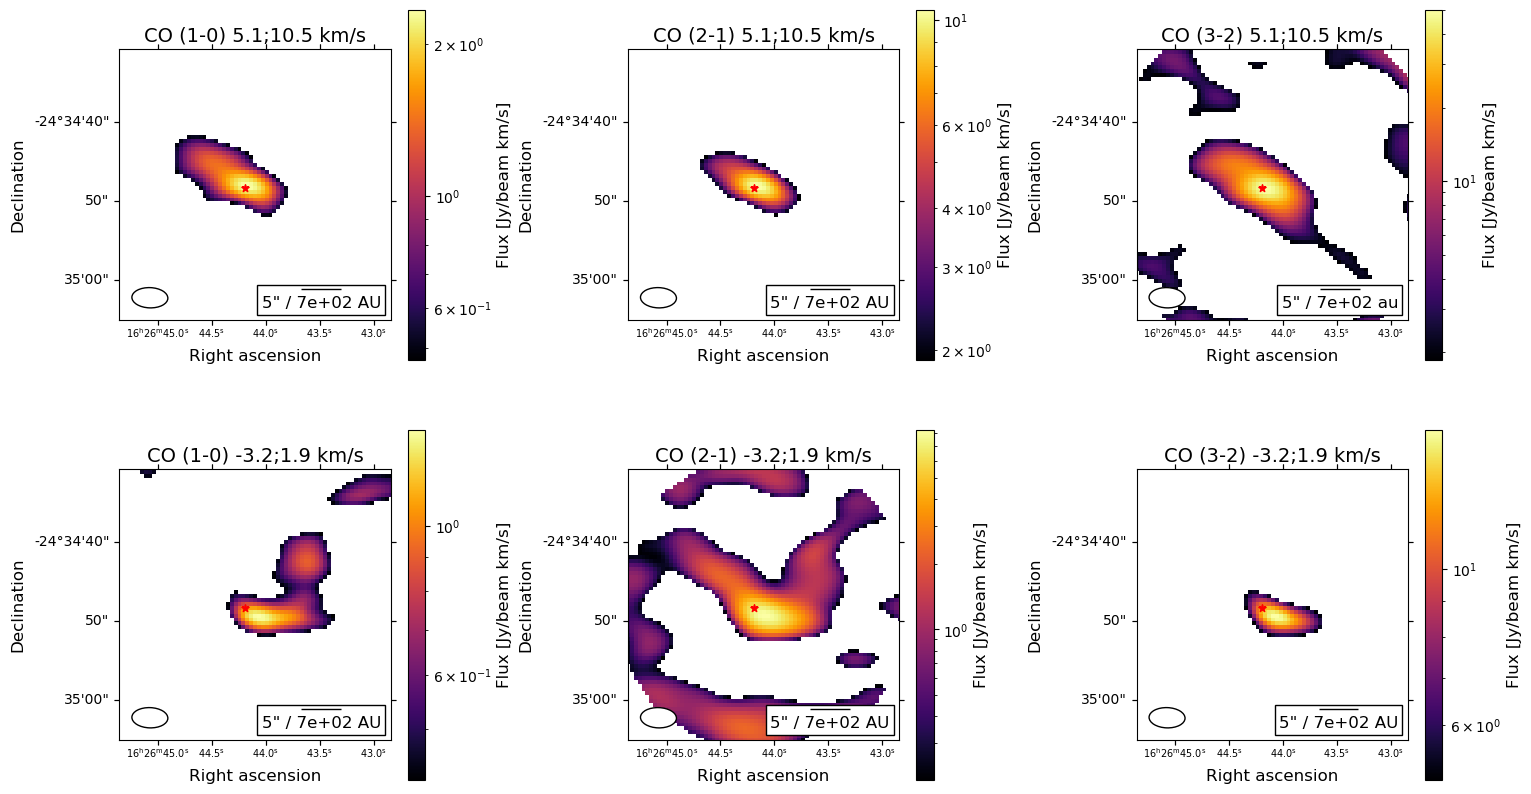

In [130]:
#here the maps are plotted
"""
ALWAYS check the wcs is the one whe reprojected to
"""
if source_name=='Oph_34':
    fig, ax = plt.subplots(2, 3, figsize=(17.5,10), subplot_kw={'projection': wcs_B3_red}) #horizontal size: 25,9.5
else:
    fig, ax = plt.subplots(2, 3, figsize=(17.5,10), subplot_kw={'projection': wcs_B7_red}) #horizontal size: 25,9.5

#CO10 redshifted
ax[0,0].imshow(B3_red_clip.value, origin='lower', cmap='inferno', norm=norm_3_red)
ax[0,0].set_title('CO (1-0) ' + red_velrange + ' km/s')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_3_red, ax=ax[0,0], label='Flux [Jy/beam km/s]')

#CO21 redshifted
ax[0,1].imshow(B6_red_clip.value, origin='lower', cmap='inferno', norm=norm_6_red)
ax[0,1].set_title('CO (2-1) ' + red_velrange + ' km/s')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_6_red, ax=ax[0,1], label='Flux [Jy/beam km/s]')

#CO32 redshifted
ax[0,2].imshow(B7_red_clip.value, origin='lower', cmap='inferno', norm=norm_7_red)
ax[0,2].set_title('CO (3-2) ' + red_velrange + ' km/s')
ax[0,2].set_xlabel('Right ascension')
ax[0,2].set_ylabel('Declination')
v.add_beam(ax=ax[0,2],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[0,2].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,2], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} au", frame=True, pad=0.3)
fig.colorbar(mappable=sm_7_red, ax=ax[0,2], label='Flux [Jy/beam km/s]')

#CO10 blueshifted
ax[1,0].imshow(B3_blue_clip.value, origin='lower', cmap='inferno', norm=norm_3_blue)
ax[1,0].set_title('CO (1-0) ' + blue_velrange + ' km/s')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_3_blue, ax=ax[1,0], label='Flux [Jy/beam km/s]')

#CO21 blueshifted
ax[1,1].imshow(B6_blue_clip.value, origin='lower', cmap='inferno', norm=norm_6_blue)
ax[1,1].set_title('CO (2-1) ' + blue_velrange + ' km/s')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_6_blue, ax=ax[1,1], label='Flux [Jy/beam km/s]')

#CO32 blueshifted
ax[1,2].imshow(B7_blue_clip.value, origin='lower', cmap='inferno', norm=norm_7_blue)
ax[1,2].set_title('CO (3-2) ' + blue_velrange + ' km/s')
ax[1,2].set_xlabel('Right ascension')
ax[1,2].set_ylabel('Declination')
v.add_beam(ax=ax[1,2],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[1,2].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,2], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_7_blue, ax=ax[1,2], label='Flux [Jy/beam km/s]')

ax[0,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[0,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[0,2].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,2].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,2].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,2].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
 
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_27' or source_name == 'Oph_29' or source_name == 'Oph_31' or source_name == 'Oph_39':
    ax[0,0].set_xlim(15,85)
    ax[0,0].set_ylim(15,85)
    ax[0,1].set_xlim(15,85)
    ax[0,1].set_ylim(15,85)
    ax[0,2].set_xlim(15,85)
    ax[0,2].set_ylim(15,85)

    ax[1,0].set_xlim(15,85)
    ax[1,0].set_ylim(15,85)
    ax[1,1].set_xlim(15,85)
    ax[1,1].set_ylim(15,85)
    ax[1,2].set_xlim(15,85)
    ax[1,2].set_ylim(15,85)

if source_name == 'Oph_34': 
    ax[0,0].set_xlim(80,200)
    ax[0,0].set_ylim(80,200)
    ax[0,1].set_xlim(80,200)
    ax[0,1].set_ylim(80,200)
    ax[0,2].set_xlim(80,200)
    ax[0,2].set_ylim(80,200)

    ax[1,0].set_xlim(80,200)
    ax[1,0].set_ylim(80,200)
    ax[1,1].set_xlim(80,200)
    ax[1,1].set_ylim(80,200)
    ax[1,2].set_xlim(80,200)
    ax[1,2].set_ylim(80,200)

plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/maps_'+source_name+'.png', bbox_inches='tight', dpi=500)

# LTE Radiative Transfer Magic:

In [131]:
"""
here we do the rotation diagram magic
"""
#beamsize, defined above in arcseconds:
cb_omega = np.pi*((beam_major).to(u.rad).value)*((beam_minor).to(u.rad).value)

#Einstein A coefficients from cmds
A_B3_CO = 10**(-7.1425) /u.s 
A_B6_CO = 10**(-6.1605) /u.s 
A_B7_CO = 10**(-5.6026) /u.s 


In [132]:
#Assuming optically thin:
def column_dens_thin(mom0, A, omega):
    """
    Determine the column density of a molecule in the optically thin limit. since it gives an overflow error, and 
    returns only infinite sometimes, we first multiply the denomenator with 1e38 and later multiply the whole again by 1e38 to get the correct units.
    """
    numerator = 4 * np.pi * mom0 
    denomenator = A * omega * c.h * c.c *1e38
    coldens = numerator / denomenator  
    return coldens.to(u.cm**(-2)) *1e38

In [133]:
#Determine the column densities in the 2 bands for the red and blueshifted lines
coldens_B3_CO_red = column_dens_thin(B3_red_clip, A_B3_CO, cb_omega)
coldens_B6_CO_red = column_dens_thin(B6_red_clip, A_B6_CO, cb_omega)
coldens_B7_CO_red = column_dens_thin(B7_red_clip, A_B7_CO, cb_omega)
coldens_B3_CO_blue = column_dens_thin(B3_blue_clip, A_B3_CO, cb_omega)
coldens_B6_CO_blue = column_dens_thin(B6_blue_clip, A_B6_CO, cb_omega)
coldens_B7_CO_blue = column_dens_thin(B7_blue_clip, A_B7_CO, cb_omega)

coldens_B3_CO_red_err = column_dens_thin(B3_red_err_clip, A_B3_CO, cb_omega) #if you ever want to take some sort of average over this, know it is not filtered yet, contains low snr values
coldens_B6_CO_red_err = column_dens_thin(B6_red_err_clip, A_B6_CO, cb_omega)
coldens_B7_CO_red_err = column_dens_thin(B7_red_err_clip, A_B7_CO, cb_omega)
coldens_B3_CO_blue_err = column_dens_thin(B3_blue_err_clip, A_B3_CO, cb_omega)
coldens_B6_CO_blue_err = column_dens_thin(B6_blue_err_clip, A_B6_CO, cb_omega)
coldens_B7_CO_blue_err = column_dens_thin(B7_blue_err_clip, A_B7_CO, cb_omega)


In [134]:
#from cdms, the degeneracies of the CO molecule
g_B3 = 3
g_B6 = 5
g_B7 = 7

#Rest frequencies
freq_B3_CO = 115271.2018 *u.Hz
freq_B6_CO = 230538.0000 *u.Hz
freq_B7_CO = 345795.9899 *u.Hz

#Lower energies
El_B3_CO = 0  * u.K#*u.cm**(-1)*c.h*c.c
El_B6_CO = 3.8450 *1.438 * u.K #*u.cm**(-1)*c.h*c.c
El_B7_CO = 11.5350*1.438 * u.K#*u.cm**(-1)*c.h*c.c

Eu_B3_CO = 3.8450 *1.438 * u.K #*u.cm**(-1)*c.h*c.c
Eu_B6_CO = 11.5350 * 1.438 * u.K
Eu_B7_CO = 23.0695 * 1.438 * u.K

In [135]:
"""
Hier doen we al het spannende fitten
"""

def line(x,a,b):
    #We fit for parameters a and b
    return a * x + b

E_values = np.array([Eu_B3_CO.value, Eu_B6_CO.value, Eu_B7_CO.value])
ln_Nu_gu_red = np.array([np.log(coldens_B3_CO_red.value/g_B3), np.log(coldens_B6_CO_red.value/g_B6), np.log(coldens_B7_CO_red.value/g_B7)])
ln_Nu_gu_red_err = np.array([(coldens_B3_CO_red_err.value/coldens_B3_CO_red.value),(coldens_B6_CO_red_err.value/coldens_B6_CO_red.value), (coldens_B7_CO_red_err.value/coldens_B7_CO_red.value)])
ln_Nu_gu_blue = np.array([np.log(coldens_B3_CO_blue.value/g_B3), np.log(coldens_B6_CO_blue.value/g_B6), np.log(coldens_B7_CO_blue.value/g_B7)])
ln_Nu_gu_blue_err = np.array([(coldens_B3_CO_blue_err.value/coldens_B3_CO_blue.value),(coldens_B6_CO_blue_err.value/coldens_B6_CO_blue.value), (coldens_B7_CO_blue_err.value/coldens_B7_CO_blue.value)])

# Prepare arrays to store the fitting parameters
params_a_red = np.zeros_like(coldens_B7_CO_red.value)
params_b_red = np.zeros_like(coldens_B7_CO_red.value)
params_a_red_err = np.zeros_like(coldens_B7_CO_red.value)
params_b_red_err = np.zeros_like(coldens_B7_CO_red.value)

# Iterate over each pixel
for i in range(len(params_a_red[:,0])):
    for j in range(len(params_a_red[0,:])):
        y_pixel = ln_Nu_gu_red[:, i, j]
        err_y_pixel = ln_Nu_gu_red_err[:, i, j]
        if np.isnan(y_pixel).any() or np.isnan(err_y_pixel).any(): # If there are any NaN values, we cannot fit the line
            # print(y_pixel)
            params_a_red[i, j] = np.nan
            params_b_red[i, j] = np.nan
            params_a_red_err[i, j] = np.nan
            params_b_red_err[i, j] = np.nan
        else:
            # popt, pcov = optimize.curve_fit(line, E_values, y_pixel, check_finite=False)
            popt, pcov = optimize.curve_fit(line, E_values, y_pixel, sigma = err_y_pixel, check_finite=False) 
            params_a_red[i, j] = popt[0]
            params_b_red[i, j] = popt[1]
            params_a_red_err[i, j] = np.sqrt(np.diag(pcov)[0])
            params_b_red_err[i, j] = np.sqrt(np.diag(pcov)[1])

# Prepare arrays to store the fitting parameters for the blue one
params_a_blue = np.zeros_like(coldens_B7_CO_blue.value)
params_b_blue = np.zeros_like(coldens_B7_CO_blue.value)
params_a_blue_err = np.zeros_like(coldens_B7_CO_blue.value)
params_b_blue_err = np.zeros_like(coldens_B7_CO_blue.value)

# Iterate over each pixel
for i in range(len(params_a_blue[:,0])):
    for j in range(len(params_a_blue[0,:])):
        y_pixel = ln_Nu_gu_blue[:, i, j]
        err_y_pixel = ln_Nu_gu_blue_err[:, i, j]
        if np.isnan(y_pixel).any(): # If there are any NaN values, we cannot fit the line
            params_a_blue[i, j] = np.nan
            params_b_blue[i, j] = np.nan
            params_a_blue_err[i, j] = np.nan
            params_b_blue_err[i, j] = np.nan
        else:
            # print(err_y_pixel)
            popt, pcov = optimize.curve_fit(line, E_values, y_pixel, sigma= err_y_pixel, check_finite=False)
            # print(popt)
            params_a_blue[i, j] = popt[0]
            params_b_blue[i, j] = popt[1]
            params_a_blue_err[i, j] = np.sqrt(np.diag(pcov)[0])
            params_b_blue_err[i, j] = np.sqrt(np.diag(pcov)[1])

T_red = (-1 / params_a_red) *u.K
T_blue = (-1 / params_a_blue) *u.K

e_T_red = (1 / params_a_red**2)   * params_a_red_err *u.K
e_T_blue = (1 / params_a_blue**2) * params_a_blue_err *u.K




In [136]:
#Checking for negative temps, this is an indicator for optically thick parts
print((T_red[T_red<0.]))
print((T_blue[T_blue<0.]))


[] K
[] K


In [137]:
#interpolate to find the partition function for each pixel
Z_CO = np.array([1.4053, 2.1824, 3.7435, 7.1223, 13.8965, 27.4545, 54.5814, 81.7184, 108.8651, 181.3025, 362.6910, 726.7430])
T = np.array([2.725, 5.000, 9.375, 18.75, 37.5, 75, 150, 225, 300, 500, 1000, 2000])* u.K


#Everything that behaves as expected in terms of temperature
temp_behaved_mask_CO_red = (T_red<200*u.K) & (T_red>1*u.K)
temp_behaved_mask_CO_blue = (T_blue<200*u.K) & (T_blue>1*u.K)

#this is the temperatures where column density behaves
Tk_CO_red_behaved = np.copy(T_red)
Tk_CO_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
Tk_CO_blue_behaved = np.copy(T_blue)
Tk_CO_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

Z_interp_CO = interp.interp1d(T, Z_CO, kind='linear', fill_value='extrapolate')

Z_CO_red = Z_interp_CO(T_red)
Z_CO_blue = Z_interp_CO(T_blue)



In [138]:
#Calculate the total column density
N_tot_red = np.exp(params_b_red) * Z_CO_red 
N_tot_blue = np.exp(params_b_blue) * Z_CO_blue

#check it it is behaved
N_tot_red_behaved = np.copy(N_tot_red)
N_tot_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
N_tot_blue_behaved = np.copy(N_tot_blue)
N_tot_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

#Calculate the error in the total column density
e_N_tot_red = np.abs(N_tot_red * params_b_red_err)
e_N_tot_red_behaved = np.copy(e_N_tot_red)
e_N_tot_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan

e_N_tot_blue = np.abs(N_tot_blue*params_b_blue_err)
e_N_tot_blue_behaved = np.copy(e_N_tot_blue)
e_N_tot_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

print(f'Total column density red: {np.mean(N_tot_red_behaved[~np.isnan(N_tot_red_behaved)]):.4}')
print(f'Total column density blue: {np.mean(N_tot_blue_behaved[~np.isnan(N_tot_blue_behaved)]):.4}')

print(f'Error in total column density red: {np.mean(e_N_tot_red_behaved[~np.isnan(e_N_tot_red_behaved)]):.4}')
print(f'Error in total column density blue: {np.mean(e_N_tot_blue_behaved[~np.isnan(e_N_tot_blue_behaved)]):.4}')

Total column density red: 3.453e+15
Total column density blue: 2.025e+15
Error in total column density red: 2.199e+15
Error in total column density blue: 5.589e+14


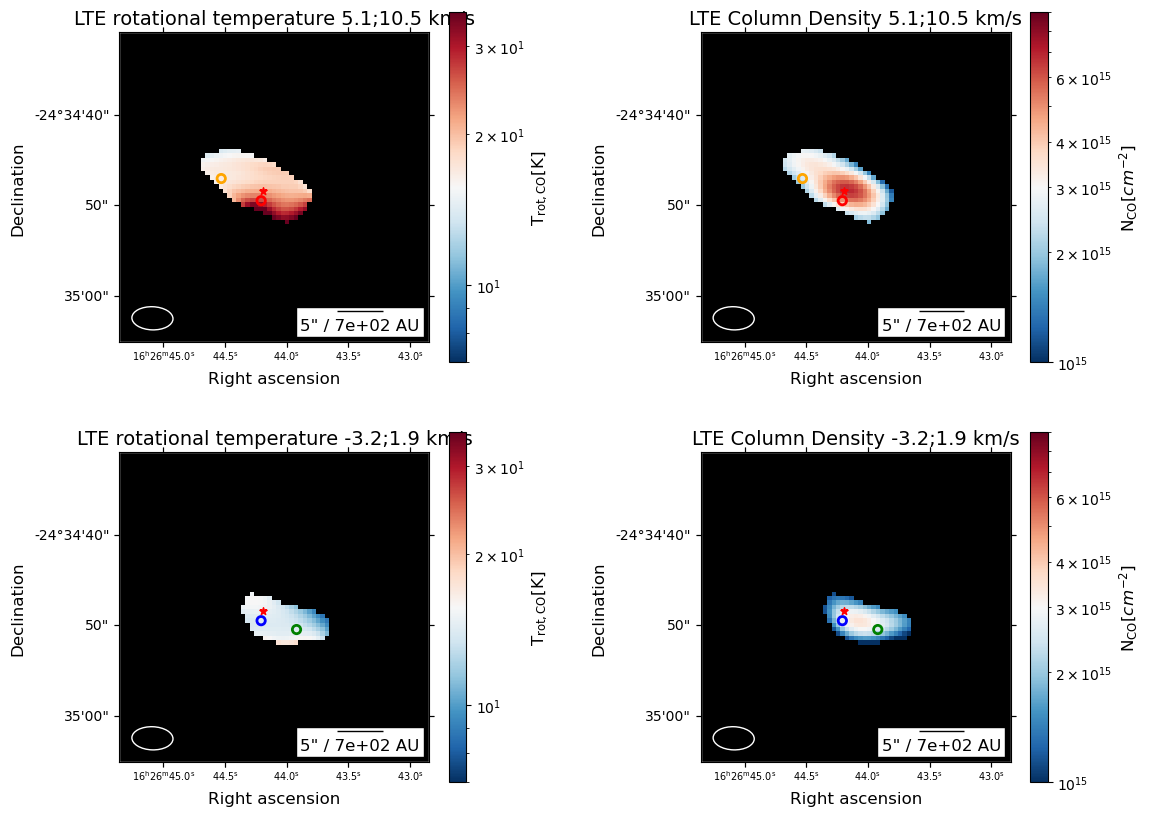

In [139]:
if source_name=='Oph_12':
    norm_T = mpl.colors.LogNorm(vmin=7e0, vmax=3.5e1)
    norm_d = mpl.colors.LogNorm(vmin=1e15, vmax=9e15)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_26':
    norm_T = mpl.colors.LogNorm(vmin=1e1, vmax=4.5e1)
    norm_d = mpl.colors.LogNorm(vmin=3e15, vmax=3e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_27':
    norm_T = mpl.colors.LogNorm(vmin=8e0, vmax=4e1)
    norm_d = mpl.colors.LogNorm(vmin=1e15, vmax=5e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_29':
    norm_T = mpl.colors.LogNorm(vmin=7e0, vmax=6e1)
    norm_d = mpl.colors.LogNorm(vmin=5e14, vmax=1e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_31':
    norm_T = mpl.colors.LogNorm(vmin=5e0, vmax=3e1)
    norm_d = mpl.colors.LogNorm(vmin=3e14, vmax=9e15)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_34':
    norm_T = mpl.colors.LogNorm(vmin=8e0, vmax=2.2e1)
    norm_d = mpl.colors.LogNorm(vmin=9e14, vmax=2e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_39':
    norm_T = mpl.colors.LogNorm(vmin=1e1, vmax=4e1)
    norm_d = mpl.colors.LogNorm(vmin=2e15, vmax=2e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)



#Do the plottomg pf rotational temperature and total column density
if source_name=='Oph_34':
    fig, ax = plt.subplots(2,2, figsize=(12.5,10), subplot_kw={'projection': wcs_B3_red}) #size horizontal: 20,9.5
else:
    fig, ax = plt.subplots(2,2, figsize=(12.5,10), subplot_kw={'projection': wcs_B7_red}) #size horizontal: 20,9.5

#temp red
ax[0,0].imshow(Tk_CO_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[0,0].set_facecolor('black')
ax[0,0].set_title('LTE rotational temperature '+red_velrange+' km/s')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
# ax[0,0].scatter(385,450, facecolors='none', edgecolors='orange', linewidth=2) #bad
# ax[0,0].scatter(350,450, facecolors='none', edgecolors='black', linewidth=2) #good
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_T, ax=ax[0,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#temp blue
ax[1,0].imshow(Tk_CO_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[1,0].set_facecolor('black')
ax[1,0].set_title('LTE rotational temperature '+blue_velrange+' km/s')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_T, ax=ax[1,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#coldens red
ax[0,1].imshow(N_tot_red_behaved, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[0,1].set_facecolor('black')
ax[0,1].set_title('LTE Column Density '+red_velrange+' km/s')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_d, ax=ax[0,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')

#coldens blue
ax[1,1].imshow(N_tot_blue_behaved, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[1,1].set_facecolor('black')
ax[1,1].set_title('LTE Column Density '+blue_velrange+' km/s')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_d, ax=ax[1,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')


if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name=='Oph_27'  or source_name == 'Oph_29' or source_name == 'Oph_31' or source_name == 'Oph_39':
    ax[0,0].set_xlim(15,85)
    ax[0,0].set_ylim(15,85)
    ax[0,1].set_xlim(15,85)
    ax[0,1].set_ylim(15,85)

    ax[1,0].set_xlim(15,85)
    ax[1,0].set_ylim(15,85)
    ax[1,1].set_xlim(15,85)
    ax[1,1].set_ylim(15,85)


if source_name == 'Oph_12' or source_name=='Oph_26' or source_name=='Oph_39':
    ax[0,0].scatter(47,47, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,1].scatter(47,47, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,0].scatter(38,52, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar
    ax[0,1].scatter(38,52, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar

    ax[1,0].scatter(47,47, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,1].scatter(47,47, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,0].scatter(55,45, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar
    ax[1,1].scatter(55,45, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar

if source_name == 'Oph_27':
    ax[0,1].scatter(47,81, facecolors='none', edgecolors='magenta', linewidth=2) #This is the one pixel that is behaving weirdly
    ax[0,0].scatter(47,81, facecolors='none', edgecolors='magenta', linewidth=2) #This is the one pixel that is behaving weirdly

    ax[0,0].scatter(47,47, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,1].scatter(47,47, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,0].scatter(60,35, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar
    ax[0,1].scatter(60,35, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar

    ax[1,0].scatter(47,47, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,1].scatter(47,47, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,0].scatter(55,45, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar
    ax[1,1].scatter(55,45, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar

if source_name == 'Oph_29':
    ax[0,0].scatter(47,47, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,1].scatter(47,47, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,0].scatter(38,52, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar
    ax[0,1].scatter(38,52, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar

    ax[1,0].scatter(47,35, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,1].scatter(47,35, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,0].scatter(55,25, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar
    ax[1,1].scatter(55,25, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar

if source_name == 'Oph_31':
    ax[0,0].scatter(47,50, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,1].scatter(47,50, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,0].scatter(42,50, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar
    ax[0,1].scatter(42,50, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar

    ax[1,0].scatter(47,47, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,1].scatter(47,47, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,0].scatter(53,43, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar
    ax[1,1].scatter(53,43, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar


if source_name == 'Oph_34': 
    ax[0,0].set_xlim(80,200)
    ax[0,0].set_ylim(80,200)
    ax[0,1].set_xlim(80,200)
    ax[0,1].set_ylim(80,200)

    ax[1,0].set_xlim(80,200)
    ax[1,0].set_ylim(80,200)
    ax[1,1].set_xlim(80,200)
    ax[1,1].set_ylim(80,200)

    ax[0,0].scatter(142,135, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,1].scatter(142,135, facecolors='none', edgecolors='red', linewidth=2) #red, close to protostar
    ax[0,0].scatter(140,125, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar
    ax[0,1].scatter(140,125, facecolors='none', edgecolors='orange', linewidth=2) #red, further from protostar

    ax[1,0].scatter(143,135, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,1].scatter(143,135, facecolors='none', edgecolors='blue', linewidth=2) #blue, close to protostar
    ax[1,0].scatter(160,135, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar
    ax[1,1].scatter(160,135, facecolors='none', edgecolors='green', linewidth=2) #blue, further from protostar


ax[0,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[0,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')


plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/LTE_tempmaps_'+source_name+'.png', dpi=500, bbox_inches='tight')

20.873674392700195 K 13.816957473754883 K
12.336331367492676 K 2.927049160003662 K
3453237327913946.0 3453237327913946.0
12.336331367492676 K 2.927049160003662 K


[]

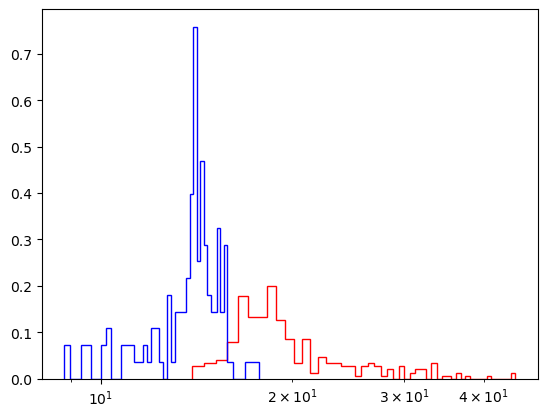

In [140]:
print(np.mean(Tk_CO_red_behaved[~np.isnan(Tk_CO_red_behaved)]), np.mean(Tk_CO_blue_behaved[~np.isnan(Tk_CO_blue_behaved)]))
print(np.mean(e_T_red[~np.isnan(e_T_red)]), np.mean(e_T_blue[~np.isnan(e_T_blue)]))


print(np.mean(N_tot_red_behaved[~np.isnan(N_tot_red_behaved)]), np.mean(N_tot_red_behaved[~np.isnan(N_tot_red_behaved)]))
print(np.mean(e_T_red[~np.isnan(e_T_red)]), np.mean(e_T_blue[~np.isnan(e_T_blue)]))

"""  
So this source is my testcase once again:
make histograms of the temperatures and column densities, to see if we can filter out the outliers. Filter at 110k?
"""
plt.hist(Tk_CO_red_behaved[~np.isnan(Tk_CO_red_behaved)].value, bins=50, histtype='step', color='red', label='red',density=True)
plt.hist(Tk_CO_blue_behaved[~np.isnan(Tk_CO_blue_behaved)].value, bins=50, histtype='step', color='blue', label='blue',density=True)
plt.semilogx()

In [141]:
"""
Here, I will check if in any of the images, the band 3 column density is lower than the band 6 column density. This would be an indicator for optically thick regions.
>This still includes pixels that might have only 2 measurements, not only 3. So ignore those.
"""

#Check if the column densities (as they appear in rotation diagram) are lower in band 3 than in band 6
print('B3 red lower than B6 red')
print(np.sum(np.log(coldens_B3_CO_red.value/g_B3) < np.log(coldens_B6_CO_red.value/g_B6)))
print('B3 blue lower than B6 blue')
print(np.sum(np.log(coldens_B3_CO_blue.value/g_B3) < np.log(coldens_B6_CO_blue.value/g_B6)))

mask_lower = (np.where(np.log(coldens_B3_CO_red.value/g_B3) < np.log(coldens_B6_CO_red.value/g_B6)))
print(T_red[mask_lower])
print(mask_lower)

B3 red lower than B6 red
0
B3 blue lower than B6 blue
0
[] K
(array([], dtype=int64), array([], dtype=int64))


Red, far from protostar 26.33894157409668 K pm 19.981630325317383 K
Red, close to protostar 16.73961639404297 K pm 7.509226322174072 K
Blue, far from protostar 14.048280715942383 K pm 1.5790915489196777 K
Blue, close to protostar 14.033357620239258 K pm 3.406155824661255 K


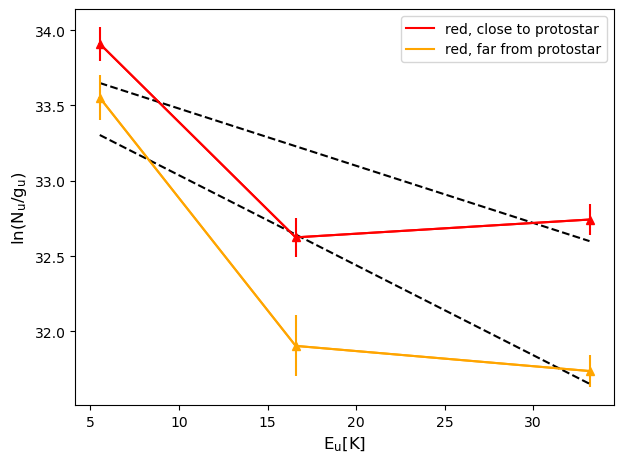

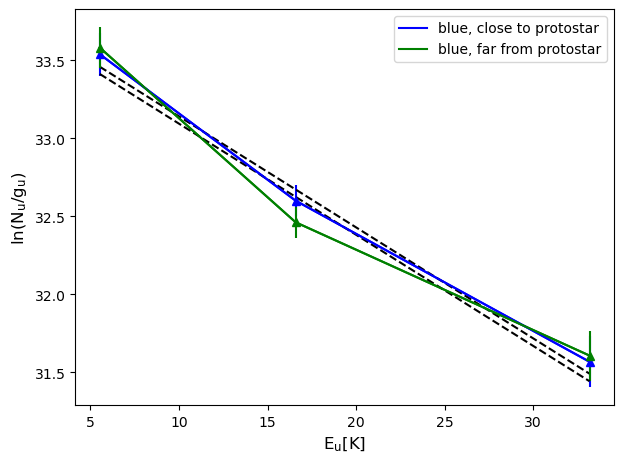

In [142]:
"""  
Now I check for that one pixel that is behaving weirdly in Oph_27, what the rotation diagram looks like
"""


if source_name=='Oph_12' or source_name=='Oph_26' or source_name=='Oph_39':
    plt.figure()
    rot_x, rot_y = 47,47 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='red',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='red',zorder=1, label='red, close to protostar')
    print('Red, far from protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 38, 52 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='orange',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='orange',zorder=1, label='red, far from protostar')
    print('Red, close to protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_red.pdf')

    plt.figure()
    rot_x, rot_y = 47,47 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='blue',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='blue',zorder=1, label='blue, close to protostar')
    print('Blue, far from protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 55, 45 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='green',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='green',zorder=1, label='blue, far from protostar')
    print('Blue, close to protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_blue.pdf')

if source_name=='Oph_27':
    plt.figure()
    rot_x, rot_y = 47, 81 #This is the single pixel that is behaving weirdly
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='magenta',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='magenta',zorder=1, label='red, funky pixel')
    print('Red, funky pixel',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 47,47 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='red',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='red',zorder=1, label='red, close to protostar')
    print('Red, far from protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 60, 35 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='orange',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='orange',zorder=1, label='red, far from protostar')
    print('Red, close to protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')

    plt.legend()

    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_red.pdf')

    plt.figure()
    rot_x, rot_y = 47,47 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='blue',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='blue',zorder=1, label='blue, close to protostar')
    print('Blue, far from protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 55, 45 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='green',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='green',zorder=1, label='blue, far from protostar')
    print('Blue, close to protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')

    plt.legend()

    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_blue.pdf')

if source_name=='Oph_29':
    plt.figure()
    rot_x, rot_y = 47,47 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='red',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='red',zorder=1, label='red, close to protostar')
    print('Red, far from protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 38, 52 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='orange',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='orange',zorder=1, label='red, far from protostar')
    print('Red, close to protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_red.pdf')

    plt.figure()
    rot_x, rot_y = 47,35 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='blue',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='blue',zorder=1, label='blue, close to protostar')
    print('Blue, far from protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 55, 25 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='green',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='green',zorder=1, label='blue, far from protostar')
    print('Blue, close to protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_blue.pdf')

if source_name=='Oph_31':
    plt.figure()
    rot_x, rot_y = 47,50 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='red',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='red',zorder=1, label='red, close to protostar')
    print('Red, far from protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 42, 50 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='orange',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='orange',zorder=1, label='red, far from protostar')
    print('Red, close to protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_red.pdf')

    plt.figure()
    rot_x, rot_y = 47,47 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='blue',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='blue',zorder=1, label='blue, close to protostar')
    print('Blue, far from protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 53, 43 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='green',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='green',zorder=1, label='blue, far from protostar')
    print('Blue, close to protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_blue.pdf')

if source_name=='Oph_34':
    plt.figure()
    rot_x, rot_y = 142,135 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='red',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='red',zorder=1, label='red, close to protostar')
    print('Red, far from protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 140, 125 
    plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='orange',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='orange',zorder=1, label='red, far from protostar')
    print('Red, close to protostar',T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
    plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_red.pdf')

    plt.figure()
    rot_x, rot_y = 143,135 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='blue',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='blue',zorder=1, label='blue, close to protostar')
    print('Blue, far from protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    rot_x, rot_y = 160, 135 
    plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y,rot_x],yerr =ln_Nu_gu_blue_err[:, rot_y, rot_x],color='green',marker='^',zorder=1)
    plt.plot(E_values,ln_Nu_gu_blue[:,rot_y,rot_x], color='green',zorder=1, label='blue, far from protostar')
    print('Blue, close to protostar',T_blue[rot_y, rot_x],'pm',e_T_blue[rot_y, rot_x])
    plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

    plt.xlabel(r'E$_{\mathrm{u}}$[K]')
    plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname=path+'plots/rotdiagrams_blue.pdf')
    

In [143]:
"""
make contour maps for unsmoothed CO21

"""

B6_red_name_unsmoothed = 'M0_maps/CO21_M0_red_unsmoothed'    #M0 map of the CO 2-1 line, band 6, redshifted
B6_blue_name_unsmoothed = 'M0_maps/CO21_M0_blue_unsmoothed'    #M0 map of the CO 2-1 line, band 6, blueshifted, unsmoothed

#Open the fits files
hdu_B6_red_unsmoothed = fits.open(path+B6_red_name_unsmoothed)
hdu_B6_blue_unsmoothed = fits.open(path+B6_blue_name_unsmoothed)

# Always manually check the beam is exactly the same for both maps, and check unit of major axis
beam_major_unsmoothed = hdu_B6_red_unsmoothed[0].header['BMAJ']*3600 *u.arcsec # Beam major axis size in arcseconds
beam_minor_unsmoothed = hdu_B6_red_unsmoothed[0].header['BMIN']*3600 *u.arcsec # Beam minor axis size in arcseconds
beam_pa_unsmoothed = hdu_B6_red_unsmoothed[0].header['BPA']*u.deg  # Beam position angle in degrees

#get the pixel size form the header, for the unsmoothed maps
pixel_size_unsmoothed=0.18 *u.arcsec 
    
#The WCS object is used to convert between pixel and world coordinates
wcs_B6_red_unsmoothed = WCS(hdu_B6_red_unsmoothed[0].header)
wcs_B6_blue_unsmoothed = WCS(hdu_B6_blue_unsmoothed[0].header)

#One of the images needs to be regridded, this can be done because both are well sampled
#This is the one where CO32 has a worse resolution than CO21
B6_red_unsmoothed = hdu_B6_red_unsmoothed[0].data *u.Jy*u.km/u.s
B6_blue_unsmoothed = hdu_B6_blue_unsmoothed[0].data *u.Jy*u.km/u.s


#RMS calculation
B6_red_rms_name_unsmoothed = 'M0_maps/CO21_M0_red_unsmoothed_rms'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B6_blue_rms_name_unsmoothed = 'M0_maps/CO21_M0_blue_unsmoothed_rms'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter


#This is now just an empty region of the map to get rms level. Later convolve with 10%
hdu_B6_red_err_unsmoothed = fits.open(path+B6_red_rms_name_unsmoothed)
hdu_B6_blue_err_unsmoothed = fits.open(path+B6_blue_rms_name_unsmoothed)


#Here we take the not-nan values to calculate the rms. The other images do still contain nan values
B6_red_rms_unsmoothed = np.sqrt(np.mean(np.square(hdu_B6_red_err_unsmoothed[0].data[hdu_B6_red_err_unsmoothed[0].data >0]) ))*u.Jy*u.km/u.s
B6_blue_rms_unsmoothed = np.sqrt(np.mean(np.square(hdu_B6_blue_err_unsmoothed[0].data[hdu_B6_blue_err_unsmoothed[0].data >0]) ))*u.Jy*u.km/u.s
print(B6_red_rms_unsmoothed, B6_blue_rms_unsmoothed)
#Also convolution with 10% systematic error

systematic_error = 0.1 # 10% systematic error
B6_red_err_unsmoothed = np.sqrt(np.square(B6_red_rms_unsmoothed) + np.square(systematic_error* B6_red_unsmoothed))
B6_blue_err_unsmoothed = np.sqrt(np.square(B6_blue_rms_unsmoothed) + np.square(systematic_error* B6_blue_unsmoothed))

hdu_B6_red_unsmoothed.close()
hdu_B6_red_err_unsmoothed.close()
hdu_B6_blue_unsmoothed.close()
hdu_B6_blue_err_unsmoothed.close()


#Determine the SNR
SNR_B6_red_unsmoothed = B6_red_unsmoothed/B6_red_err_unsmoothed
SNR_B6_blue_unsmoothed = B6_blue_unsmoothed/B6_blue_err_unsmoothed

clip = 3

B6_red_clip_unsmoothed = np.copy(B6_red_unsmoothed)
B6_blue_clip_unsmoothed = np.copy(B6_blue_unsmoothed)

B6_red_clip_unsmoothed[SNR_B6_red_unsmoothed<clip] = np.nan
B6_blue_clip_unsmoothed[SNR_B6_blue_unsmoothed<clip] = np.nan

B6_red_clip_unsmoothed[B6_red_clip_unsmoothed==0] = np.nan
B6_blue_clip_unsmoothed[B6_blue_clip_unsmoothed==0] = np.nan

0.13351662456989288 Jy km / s 0.1184566468000412 Jy km / s


14.296126
Length of the line blue lobe: 893.8 pm 191.1 AU
Length of the line red lobe: 969.5 pm 194.8 AU
Outdated uncertainty
Delta V blue 7.0 km / s pm 0.7 km / s
Delta V red 7.1 km / s pm 0.71 km / s
Outdated uncertainty
The blue dynamic time is 605.3 pm 142.9 years
The red dynamic time is 647.3 pm 145.3 years


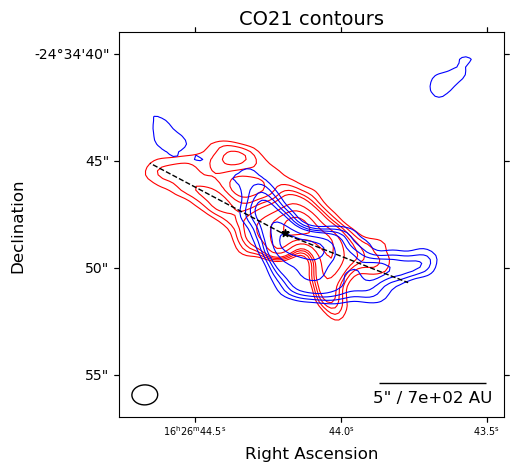

In [144]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': wcs_B6_red_unsmoothed}) #size horizontal: 20,9.5
plt.title('CO21 contours')
# Set the aspect ratio to be equal
ax.set_aspect('equal')


contourlevels_red=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_red_rms_unsmoothed.value
# Plot the contours of B6_red_clip. since it is already clipped at 3 sigma, no need to do it again. This goed allright, it does not need to be 3sigma for b6 _and_ b7.
contours_red=ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8)

# Plot the contours of B6_blue_clip
contourlevels_blue=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_blue_rms_unsmoothed.value
contours_blue=ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8)

print(np.max(B6_blue_clip_unsmoothed.value[np.isfinite(B6_blue_clip_unsmoothed.value)]) / B6_blue_rms_unsmoothed.value)



# Set the limits for zooming
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_39':
    ax.set_xlim(75,175)
    ax.set_ylim(75,175)

if source_name == 'Oph_27': 
    ax.set_xlim(80,180)
    ax.set_ylim(45,145)

if source_name == 'Oph_29': 
    ax.set_xlim(50,190)
    ax.set_ylim(30,170)

if source_name == 'Oph_31': 
    ax.set_xlim(90,210)
    ax.set_ylim(65,185)

if source_name == 'Oph_34': 
    ax.set_xlim(85,160)
    ax.set_ylim(70,145)

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

#rotate the y ticklabels
plt.yticks(rotation=90)


v.add_beam(ax=ax,major=beam_major_unsmoothed, minor=beam_minor_unsmoothed, angle=beam_pa_unsmoothed, color='none', edgecolor='black')
ax.tick_params(axis='x', labelsize=7)
v.add_scalebar(ax, length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU")

ax.scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax.get_transform('fk5'), s=30, 
              color='black', marker='*', label='All cores', zorder=100)


if source_name == 'Oph_12':
    point1_blue = (117, 123)  # protostar
    point2_blue = (150, 110)  # Furthest point from the protostar
    ax.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', linestyle='--', linewidth=1)
    line_length_blue = np.sqrt((point2_blue[0] - point1_blue[0])**2 + (point2_blue[1] - point1_blue[1])**2)

    point1_red = (117, 123)  # protostar    
    point2_red = (83, 141)  # Furthest point from the protostar
    ax.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', linestyle='--', linewidth=1)
    line_length_red = np.sqrt((point2_red[0] - point1_red[0])**2 + (point2_red[1] - point1_red[1])**2)

    V_blue = np.abs(-2.7 - 4.3) * u.km / u.s
    V_red = np.abs(11.4 - 4.3) * u.km / u.s

if source_name == 'Oph_26':
    point1_blue = (123, 120)  # protostar
    point2_blue = (151, 113)  # Furthest point from the protostar
    new_point2_blue = (151, 130)  # For second iteration
    ax.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', linestyle='--', linewidth=1)
    ax.plot([point1_blue[0], new_point2_blue[0]], [point1_blue[1], new_point2_blue[1]], color='black', linestyle='-.', linewidth=1)
    line_length_blue = np.sqrt((point2_blue[0] - point1_blue[0])**2 + (point2_blue[1] - point1_blue[1])**2)

    point1_red = (123, 120)  # protostar    
    point2_red = (99, 120)  # Furthest point from the protostar
    ax.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', linestyle='--', linewidth=1)
    line_length_red = np.sqrt((point2_red[0] - point1_red[0])**2 + (point2_red[1] - point1_red[1])**2)

    V_blue = np.abs(-6.8 - 3.8) * u.km / u.s
    V_red = np.abs(12.5 - 3.8) * u.km / u.s

if source_name == 'Oph_27':
    point1_blue = (119, 119)  # protostar
    point2_blue = (132, 136)  # Furthest point from the protostar
    ax.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', linestyle='--', linewidth=1)
    line_length_blue = np.sqrt((point2_blue[0] - point1_blue[0])**2 + (point2_blue[1] - point1_blue[1])**2)

    point1_red = (119, 119)  # protostar    
    point2_red = (116, 109)  # Furthest point from the protostar
    ax.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', linestyle='--', linewidth=1)
    ax.scatter(point1_red[0], point1_red[1], marker='o', color='black', s=30, zorder=100)
    line_length_red = np.sqrt((point2_red[0] - point1_red[0])**2 + (point2_red[1] - point1_red[1])**2)

    V_blue = np.abs(-11.4 - 3.8) * u.km / u.s
    V_red = np.abs(13.3 - 3.8) * u.km / u.s

if source_name == 'Oph_29':
    #Do not include
    point1_blue = (119, 119)  # protostar
    point2_blue = (119, 119)  # Furthest point from the protostar
    ax.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', linestyle='--', linewidth=1)
    line_length_blue = np.sqrt((point2_blue[0] - point1_blue[0])**2 + (point2_blue[1] - point1_blue[1])**2)

    point1_red = (119, 123)  # protostar    
    point2_red = (94, 145.5)  # Furthest point from the protostar
    ax.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', linestyle='--', linewidth=1)
    line_length_red = np.sqrt((point2_red[0] - point1_red[0])**2 + (point2_red[1] - point1_red[1])**2)

    V_blue = np.abs(-6 - 4.5) * u.km / u.s * 0
    V_red = np.abs(7.6 - 4.5) * u.km / u.s

if source_name == 'Oph_31':
    #Do not include
    point1_blue = (119, 119)  # protostar
    point2_blue = (119, 119)  # Furthest point from the protostar
    ax.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', linestyle='--', linewidth=1)
    line_length_blue = np.sqrt((point2_blue[0] - point1_blue[0])**2 + (point2_blue[1] - point1_blue[1])**2)

    point1_red = (123, 118)  # protostar    
    point2_red = (93, 120)  # Furthest point from the protostar
    ax.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', linestyle='--', linewidth=1)
    ax.scatter(point1_red[0], point1_red[1], marker='o', color='black', s=30, zorder=100)
    line_length_red = np.sqrt((point2_red[0] - point1_red[0])**2 + (point2_red[1] - point1_red[1])**2)

    V_blue = np.abs(-1.4 - 2.7) * u.km / u.s *0
    V_red = np.abs(9 - 2.7) * u.km / u.s

if source_name == 'Oph_34':
    #Do not include
    point1_blue = (122, 120)  # protostar
    point2_blue = (142, 94.5)  # Furthest point from the protostar
    ax.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', linestyle='--', linewidth=1)
    line_length_blue = np.sqrt((point2_blue[0] - point1_blue[0])**2 + (point2_blue[1] - point1_blue[1])**2)

    point1_red = (122, 120)  # protostar    
    point2_red = (112, 125)  # Furthest point from the protostar
    ax.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', linestyle='--', linewidth=1)
    ax.scatter(point1_red[0], point1_red[1], marker='o', color='black', s=30, zorder=100)
    line_length_red = np.sqrt((point2_red[0] - point1_red[0])**2 + (point2_red[1] - point1_red[1])**2)

    V_blue = np.abs(-9.2 - 2.7) * u.km / u.s
    V_red = np.abs(5.1 - 2.7) * u.km / u.s

if source_name == 'Oph_39':
    #Do not include
    point1_blue = (118, 118)  # protostar
    point2_blue = (157, 115)  # Furthest point from the protostar
    ax.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', linestyle='--', linewidth=1)
    line_length_blue = np.sqrt((point2_blue[0] - point1_blue[0])**2 + (point2_blue[1] - point1_blue[1])**2)

    point1_red = (118, 118)  # protostar    
    point2_red = (102, 120)  # Furthest point from the protostar
    ax.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', linestyle='--', linewidth=1)
    ax.scatter(point1_red[0], point1_red[1], marker='o', color='black', s=30, zorder=100)
    line_length_red = np.sqrt((point2_red[0] - point1_red[0])**2 + (point2_red[1] - point1_red[1])**2)

    V_blue = np.abs(-4.8 - 3) * u.km / u.s
    V_red = np.abs(10.9 - 3) * u.km / u.s

# Show the plot
# plt.tight_layout()
plt.savefig(path+'plots/CO21_contours_'+source_name+'.png', dpi=500, bbox_inches='tight')

#Uncertainty in radius is 10% of lobe convolved with major axis of beam
radius_blue = ((line_length_blue * pixel_size_unsmoothed).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_blue = np.sqrt( np.square(0.1* radius_blue) + np.square((beam_major_unsmoothed.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line blue lobe: {radius_blue.value:.4} pm {e_radius_blue.value:.4} AU")
radius_red = ((line_length_red * pixel_size_unsmoothed).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_red = np.sqrt( np.square(0.1* radius_red) + np.square((beam_major_unsmoothed.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line red lobe: {radius_red.value:.4} pm {e_radius_red.value:.4} AU")

print("Outdated uncertainty")
e_V_blue = 0.1 * V_blue
e_V_red = 0.1 * V_red
print(f"Delta V blue {V_blue:.4} pm {e_V_blue:.4}")
print(f"Delta V red {V_red:.4} pm {e_V_red:.4}")


print ("Outdated uncertainty")
t_dyn_blue = (radius_blue / V_blue).to(u.yr)
e_t_dyn_blue = np.sqrt(np.square(e_radius_blue/V_blue)+np.square(radius_blue * e_V_blue/ V_blue **2)).to(u.yr)
print(f"The blue dynamic time is {t_dyn_blue.value:.4} pm {e_t_dyn_blue.value:.4} years")

t_dyn_red = (radius_red / V_red).to(u.yr)
e_t_dyn_red = np.sqrt(np.square(e_radius_red/V_red)+np.square(radius_red * e_V_red/ V_red **2)).to(u.yr)
print(f"The red dynamic time is {t_dyn_red.value:.4} pm {e_t_dyn_red.value:.4} years")

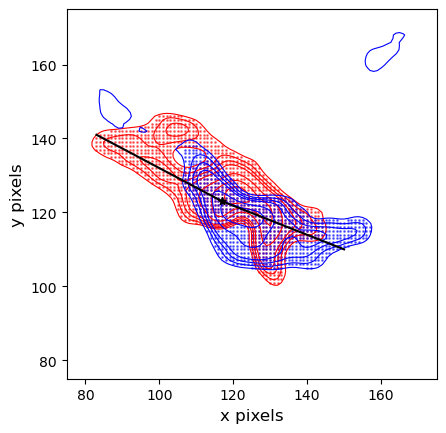

/var/tmp/ballieux/ipykernel_1074867/1012519801.py:17: RuntimeWarning: invalid value encountered in divide
  cos_theta = dot_products / (magnitude_v1 * magnitudes_v2)


In [145]:
def calculate_angles(v1, v2_x_array, v2_y_array):
    # Vector 1: a 2D vector
    x1, y1 = v1
    
    # Vector 2: arrays of x and y coordinates
    x2_array = np.array(v2_x_array)
    y2_array = np.array(v2_y_array)
    
    # Compute dot products between v1 and each vector in v2
    dot_products = x1 * x2_array + y1 * y2_array
    
    # Magnitudes of vector 1 and each vector in v2
    magnitude_v1 = np.sqrt(x1**2 + y1**2)
    magnitudes_v2 = np.sqrt(x2_array**2 + y2_array**2)
    
    # Compute cosine of angles
    cos_theta = dot_products / (magnitude_v1 * magnitudes_v2)
    
    # To avoid any numerical issues with floating-point precision
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the cross products to determine sign of the angle (+ and - signs are dependent on which vector goes first)
    cross_products =  y1 * x2_array - x1 * y2_array
    # Compute the angles

    angles_radians = np.arccos(cos_theta)
    angles_degrees = np.degrees(angles_radians)

    # Assign negative sign to angles where the cross product is negative
    signed_angles = np.where(cross_products < 0, -angles_radians, angles_radians)
    signed_angles_degrees = np.degrees(signed_angles)
    
    return angles_radians, angles_degrees, signed_angles, signed_angles_degrees

#The vector of the initial guess axis, with protostar as middle point
vector_axis_red = np.array(point2_red) - np.array(point1_red)
vector_axis_blue = np.array(point2_blue) - np.array(point1_blue)

if source_name == 'Oph_26':
    vector_axis_blue = np.array(new_point2_blue) - np.array(point1_blue)

#The red outflow indices where it is not nan, clipped at 3 sigma
outflow_red= np.where(B6_red_clip_unsmoothed.value>0.)
outflow_red_x = outflow_red[1] 
outflow_red_y = outflow_red[0]

#The red outflow indices where it is not nan, clipped at 3 sigma
outflow_blue = np.where(B6_blue_clip_unsmoothed.value>0.)
outflow_blue_x = outflow_blue[1]
outflow_blue_y = outflow_blue[0]

#Plot the unmasked outflow
# plt.scatter(outflow_red_x, outflow_red_y, s=1, color='red')
# plt.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', zorder=20)
# plt.scatter(outflow_blue_x, outflow_blue_y, s=1, color='blue')
# plt.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', zorder=20)
# plt.show()

# Now do the proper clipping, make sure entire lobe filled with pixels, and nowhere else
if source_name == 'Oph_12':
    outflow_red_mask= np.where((outflow_red_x>80)&(outflow_red_x<160)&(outflow_red_y>100)&(outflow_red_y<150))
    outflow_blue_mask= np.where((outflow_blue_x>80)&(outflow_blue_x<160)&(outflow_blue_y>90)&(outflow_blue_y<145))

if source_name == 'Oph_26':
    outflow_red_mask= np.where((outflow_red_x>80)&(outflow_red_x<130)&(outflow_red_y>100)&(outflow_red_y<150))
    outflow_blue_mask= np.where((outflow_blue_x>80)&(outflow_blue_x<160)&(outflow_blue_y>100)&(outflow_blue_y<160))

if source_name == 'Oph_27':
    outflow_red_mask= np.where((outflow_red_x>102)&(outflow_red_x<140)&(outflow_red_y>100)&(outflow_red_y<140))
    outflow_blue_mask= np.where((outflow_blue_x>90)&(outflow_blue_x<140)&(outflow_blue_y>100)&(outflow_blue_y<140))

if source_name == 'Oph_29':
    outflow_red_mask= np.where((outflow_red_x>80)&(outflow_red_x<140)&(outflow_red_y>100)&(outflow_red_y<150)&(outflow_red_x>outflow_red_y-45)&(outflow_red_x<outflow_red_y-5))
    outflow_blue_mask= np.where((outflow_blue_x>90)&(outflow_blue_x<140)&(outflow_blue_y>100)&(outflow_blue_y<140)) #irrelevant

if source_name == 'Oph_31':
    outflow_red_mask= np.where((outflow_red_x>90)&(outflow_red_x<145)&(outflow_red_y>90)&(outflow_red_y<140))
    outflow_blue_mask= np.where((outflow_blue_x>90)&(outflow_blue_x<140)&(outflow_blue_y>100)&(outflow_blue_y<140)) #irrelevant

if source_name == 'Oph_34':
    outflow_red_mask= np.where((outflow_red_x>80)&(outflow_red_x<145)&(outflow_red_y>106)&(outflow_red_y<140))
    outflow_blue_mask= np.where((outflow_blue_x>90)&(outflow_blue_x<175)&(outflow_blue_y>65)&(outflow_blue_y<140)\
                                &(outflow_blue_y>-2*outflow_blue_x + 335)&(outflow_blue_y>-outflow_blue_x + 215))

if source_name == 'Oph_39':
    outflow_red_mask= np.where((outflow_red_x>90)&(outflow_red_x<130)&(outflow_red_y>105)&(outflow_red_y<150))
    outflow_blue_mask= np.where((outflow_blue_x>90)&(outflow_blue_x<170)&(outflow_blue_y>90)&(outflow_blue_y<150))


outflow_red_x_masked = outflow_red_x[outflow_red_mask]
outflow_red_y_masked = outflow_red_y[outflow_red_mask]

outflow_blue_x_masked = outflow_blue_x[outflow_blue_mask]
outflow_blue_y_masked = outflow_blue_y[outflow_blue_mask]

#Check the masking
fig = plt.figure()
ax = fig.add_subplot(111)

#central protostar
plt.scatter(point1_red[0], point1_red[1], s=30, color='black', zorder=10, marker='*')

#red
plt.scatter(outflow_red_x_masked, outflow_red_y_masked, s=1, color='red', alpha=0.5)
plt.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', zorder=20)
contourlevels_red=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_red_rms_unsmoothed
contours_red=ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8) #Only place we use unclipped M0 maps

if source_name != 'Oph_29' and source_name != 'Oph_31':
    plt.scatter(outflow_blue_x_masked, outflow_blue_y_masked, s=1, color='blue', alpha=0.5)
    plt.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', zorder=20)
    contourlevels_blue=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_blue_rms_unsmoothed
    contours_blue=ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8) #Only place we use unclipped M0 maps

    if source_name == 'Oph_26':
        plt.plot([point1_blue[0], new_point2_blue[0]], [point1_blue[1], new_point2_blue[1]], color='black', linestyle='-.', linewidth=1)

# if source_name == 'Oph_12': #TODO:make all of these limits such that the figures plot nicely
#     ax.set_xlim(80,160)
#     ax.set_ylim(90,160)

# if source_name == 'Oph_26':
#     ax.set_xlim(80,160)
#     ax.set_ylim(90,160)

# if source_name == 'Oph_27':
#     ax.set_xlim(90,145)
#     ax.set_ylim(100,140)

# if source_name == 'Oph_29':
#     ax.set_xlim(75,150)
#     ax.set_ylim(100,155)

# if source_name == 'Oph_31':
#     ax.set_xlim(85,150)
#     ax.set_ylim(90,145)

# if source_name == 'Oph_34':
#     ax.set_xlim(75,160)
#     ax.set_ylim(60,155)

# if source_name == 'Oph_39':
#     ax.set_xlim(90,170)
#     ax.set_ylim(90,160)

# Set the limits for zooming
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_39':
    ax.set_xlim(75,175)
    ax.set_ylim(75,175)

if source_name == 'Oph_27': 
    ax.set_xlim(80,180)
    ax.set_ylim(45,145)

if source_name == 'Oph_29': 
    ax.set_xlim(50,190)
    ax.set_ylim(30,170)

if source_name == 'Oph_31': 
    ax.set_xlim(90,210)
    ax.set_ylim(65,185)

if source_name == 'Oph_34': 
    ax.set_xlim(85,160)
    ax.set_ylim(70,145)

plt.xlabel('x pixels')
plt.ylabel('y pixels')
ax.set_aspect('equal')
plt.savefig(fname=path+'plots/contour+pixels_'+source_name+'.png', dpi=300, bbox_inches='tight')
plt.show()

#For each pixel, determine the vector between that pixel and the protostar
vector_pixel_x_red = outflow_red_x_masked - point1_red[0]
vector_pixel_y_red = outflow_red_y_masked - point1_red[1]
vectors_pixel_red = np.array([vector_pixel_x_red, vector_pixel_y_red])
angles_radians_red, angles_degrees_red, signed_angles_radians_red, signed_angles_degrees_red = calculate_angles(vector_axis_red, vector_pixel_x_red, vector_pixel_y_red)
signed_angles_degrees_red[signed_angles_degrees_red>90] = 180 - signed_angles_degrees_red[signed_angles_degrees_red>90]
signed_angles_degrees_red[signed_angles_degrees_red<-90] = -180 - signed_angles_degrees_red[signed_angles_degrees_red<-90]

vector_pixel_x_blue = outflow_blue_x_masked - point1_blue[0]
vector_pixel_y_blue = outflow_blue_y_masked - point1_blue[1]
vectors_pixel_blue = np.array([vector_pixel_x_blue, vector_pixel_y_blue])
angles_radians_blue, angles_degrees_blue, signed_angles_radians_blue, signed_angles_degrees_blue = calculate_angles(vector_axis_blue, vector_pixel_x_blue, vector_pixel_y_blue)

signed_angles_degrees_blue[signed_angles_degrees_blue>90] = 180 - signed_angles_degrees_blue[signed_angles_degrees_blue>90]
signed_angles_degrees_blue[signed_angles_degrees_blue<-90] = -180 - signed_angles_degrees_blue[signed_angles_degrees_blue<-90]

# plt.figure(figsize=(7,4))
# plt.hist(signed_angles_degrees_red, bins=15, histtype='step', color='red', label='redshifted lobe')
# # plt.hist(angles_degrees_red_90, bins=20, histtype='step', color='red', label='redshifted lobe')
# # if source_name != 'Oph_29' and source_name != 'Oph_31':
# #     plt.hist(angles_degrees_blue_90, bins=20, histtype='step', color='blue', label='blueshifted lobe')
# if source_name != 'Oph_29' and source_name != 'Oph_31':
#     plt.hist(signed_angles_degrees_blue, bins=20, histtype='step', color='blue', label='blueshifted lobe')    
# plt.xlabel('Angle between pixel and outflow axis in degrees')

# plt.legend()
# plt.show()

[ 11  12  13  12  13  17  53  51  78 136 150 128  86  81  55  41  43  21
  30  32]
[  6   6  12  14  20  28  30  46  93 124  91  78  59  46  38  31  28  27
  18  16]
The red outflow angle would then be: 90.5 pm 7.2 degrees
The blue outflow angle would then be: 95.8 pm 8.6 degrees


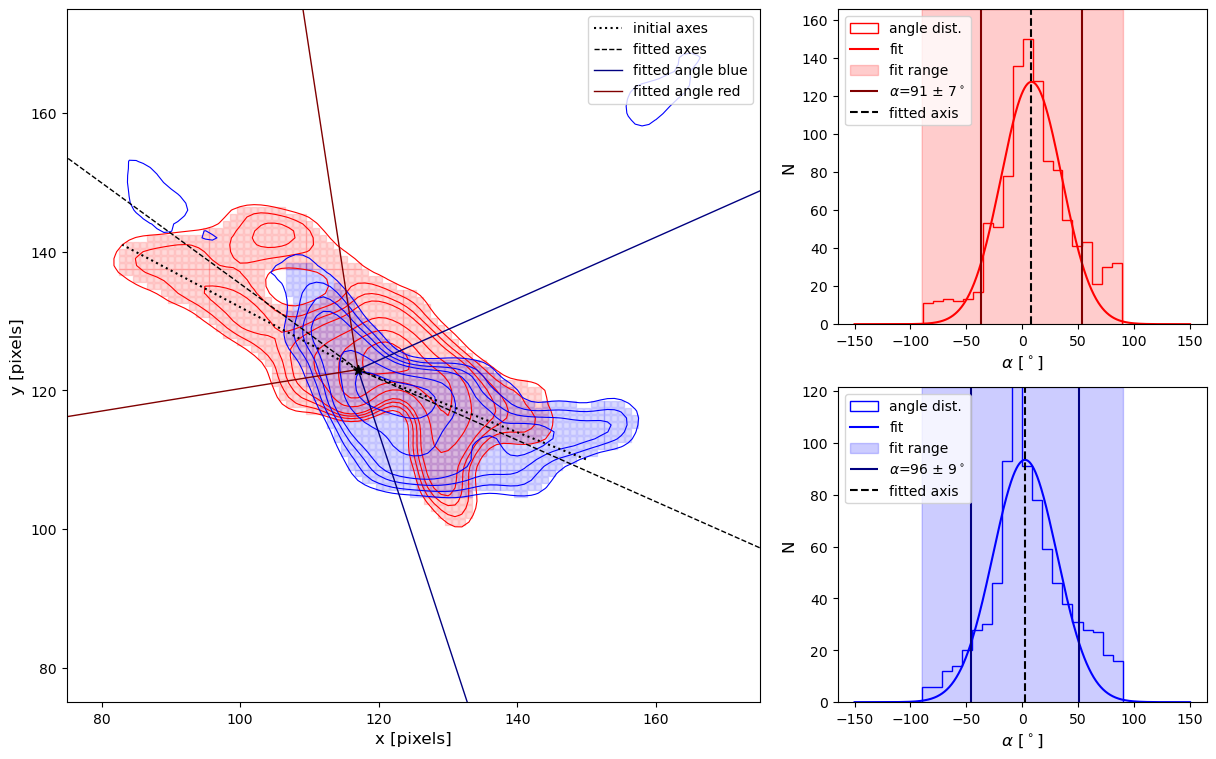

In [146]:
"""
Here, calculate the gaussian distribution of these angles
"""

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

#fitting parameters
if source_name == 'Oph_12':
    red_min = -90
    red_max = 90
    bins_red = 20
    p0_red=[120, 0, 50]

    blue_min = -90
    blue_max = 90
    bins_blue = 20
    p0_blue=[120, 0, 50]

if source_name == 'Oph_26':
    red_min_left = -90
    red_max_left = -15
    red_min_right = 30
    red_max_right = 90
    bins_red = 30
    p0_red=[100, 0, 50]

    blue_min = -70
    blue_max = 90
    bins_blue = 15
    p0_blue=[100, 0, 50]

if source_name == 'Oph_27':
    red_min_left = -90
    red_max_left = -50
    red_min_right = 40
    red_max_right = 50
    bins_red = 20
    p0_red=[50, 0, 50]

    blue_min = -60
    blue_max = 90
    bins_blue = 15
    p0_blue=[50, 0, 50]

if source_name == 'Oph_29': #no blue
    red_min_left = -90
    red_max_left = 0
    red_min_right = 0
    red_max_right = 90
    bins_red = 20
    p0_red=[70, 0, 50]

if source_name == 'Oph_31': #no blue
    red_min = -90
    red_max = 90
    bins_red = 30
    p0_red=[100, 0, 50]

if source_name == 'Oph_34':
    red_min_left = -90
    red_max_left = -45
    red_min_right = 25
    red_max_right = 90
    bins_red = 15
    p0_red=[100, 0, 50]

    blue_min_left = -90
    blue_max_left = -40
    blue_min_right = 30
    blue_max_right = 90
    bins_blue = 20
    p0_blue=[250, 0, 50]

if source_name == 'Oph_39':
    red_min_left = -25
    red_max_left = 40
    red_min_right = 65
    red_max_right = 90
    bins_red = 20
    p0_red=[50, 50, 50]

    blue_min = -90
    blue_max = 40
    bins_blue = 20
    p0_blue=[250, 0, 50]

#Make the histograms
signed_angles_degrees_red_finite = signed_angles_degrees_red[np.isfinite(signed_angles_degrees_red)] #Deal with any nan angles
hist_red, binedges_red = np.histogram(signed_angles_degrees_red_finite, bins=bins_red) #make the histogram so we can fit
bincenters_red = np.mean(np.vstack([binedges_red[0:-1],binedges_red[1:]]), axis=0) #Ensure we have an array of bincenters
print(hist_red)

if source_name != 'Oph_29' and source_name != 'Oph_31':
    signed_angles_degrees_blue_finite = signed_angles_degrees_blue[np.isfinite(signed_angles_degrees_blue)] #Deal woth any nan angles
    hist_blue, binedges_blue = np.histogram(signed_angles_degrees_blue_finite, bins=bins_blue) #make the histogram so we can fit
    bincenters_blue = np.mean(np.vstack([binedges_blue[0:-1],binedges_blue[1:]]), axis=0) #Ensure we have an array of bincenters
    print(hist_blue)

#Do the masking
if (source_name != 'Oph_26') and (source_name != 'Oph_27') and (source_name != 'Oph_29') and (source_name != 'Oph_34') and (source_name != 'Oph_39') : #no cavities
    mask_red = (bincenters_red >= red_min) & (bincenters_red <= red_max) #here we mask out anything we do not want to include
    x_fit_red = bincenters_red[mask_red] #masked bincenters
    y_fit_red = hist_red[mask_red] #masked histogram for fitting

if (source_name == 'Oph_26') or (source_name == 'Oph_27') or (source_name == 'Oph_29') or (source_name == 'Oph_34') or (source_name == 'Oph_39'): #these have a cavity we want to filter out in the red
    mask_red = ((bincenters_red >= red_min_left) & (bincenters_red <= red_max_left)) \
          | ((bincenters_red >= red_min_right) & (bincenters_red <= red_max_right))  #here we mask out anything we do not want to include
    x_fit_red = bincenters_red[mask_red] #masked bincenters
    y_fit_red = hist_red[mask_red] #masked histogram for fitting

if source_name != 'Oph_29' and source_name != 'Oph_31' and source_name != 'Oph_34': #Oph_29 and Oph_31 do not have a blue lobe, oph34 has a cavity
    mask_blue = (bincenters_blue >= blue_min) & (bincenters_blue <= blue_max) #here we mask out anything we od not want to include
    x_fit_blue = bincenters_blue[mask_blue] #masked bincenters
    y_fit_blue = hist_blue[mask_blue] #masked histogram for fitting

if source_name == 'Oph_34': #Oph_34 has a cavity
    mask_blue = ((bincenters_blue >= blue_min_left) & (bincenters_blue <= blue_max_left)) \
          | ((bincenters_blue >= blue_min_right) & (bincenters_blue <= blue_max_right))#here we mask out anything we od not want to include
    x_fit_blue = bincenters_blue[mask_blue] #masked bincenters
    y_fit_blue = hist_blue[mask_blue] #masked histogram for fitting


#The fitting for red
popt_red, pcov_red = optimize.curve_fit(gaussian, x_fit_red, y_fit_red, p0=p0_red, maxfev=100000)
a_red, mu_red, sigma_red = popt_red[0], popt_red[1], popt_red[2]
e_sigma_red = np.sqrt(np.diag(pcov_red))[2]
fwqm_red = 2 * sigma_red * np.sqrt(2 * np.log(4))
e_fwqm_red = 2 * e_sigma_red * np.sqrt(2 * np.log(4))

#The fitting for blue, except for Oph_29 and Oph_31
if source_name != 'Oph_29'and source_name != 'Oph_31':
    popt_blue, pcov_blue = optimize.curve_fit(gaussian, x_fit_blue, y_fit_blue, p0=p0_blue)
    a_blue, mu_blue, sigma_blue = popt_blue[0], popt_blue[1], popt_blue[2]
    e_sigma_blue = np.sqrt(np.diag(pcov_blue))[2]
    fwqm_blue = 2 * sigma_blue * np.sqrt(2 * np.log(4))
    e_fwqm_blue = 2 * e_sigma_blue * np.sqrt(2 * np.log(4))


print(f'The red outflow angle would then be: {fwqm_red:.1f} pm {e_fwqm_red:.1f} degrees')
if source_name != 'Oph_29' and source_name != 'Oph_31':
    print(f'The blue outflow angle would then be: {fwqm_blue:.1f} pm {e_fwqm_blue:.1f} degrees')

#for plotting only
x_plot = np.linspace(-150, 150, 1000)
y_plot_red = np.linspace(0,a_red*1.3,1000)
y_plot_blue = np.linspace(0,a_blue*1.3,1000)

# Create the figure
fig = plt.figure(figsize=(15, 9))  # Adjust figsize as needed

# Define a 2x2 GridSpec, where we span the first column vertically
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], wspace=0.1)  # Make the first column wider

ax1 = fig.add_subplot(gs[:, 0])

#central protostar
ax1.scatter(point1_red[0], point1_red[1], s=50, color='black', zorder=10, marker='*')

#red
ax1.scatter(outflow_red_x_masked, outflow_red_y_masked, s=14, color='red', alpha=0.15, marker='s')
ax1.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', zorder=30, linewidth=1.5, linestyle=':', label='initial axes')
contourlevels_red=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_red_rms_unsmoothed
contours_red=ax1.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8) #Only place we use unclipped M0 maps

if source_name != 'Oph_29' and source_name != 'Oph_31':
    ax1.scatter(outflow_blue_x_masked, outflow_blue_y_masked, s=14, color='blue', alpha=0.15, marker='s')
ax1.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', zorder=30, linewidth=1.5, linestyle=':')
contourlevels_blue=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_blue_rms_unsmoothed
contours_blue=ax1.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8) #Only place we use unclipped M0 maps
if source_name == 'Oph_26':
    ax1.plot([point1_blue[0], new_point2_blue[0]], [point1_blue[1], new_point2_blue[1]], color='black', linestyle='-.', linewidth=1, label='second iteration axis')


# Set the limits for zooming
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_39':
    ax1.set_xlim(75,175)
    ax1.set_ylim(75,175)

if source_name == 'Oph_27': 
    ax1.set_xlim(80,180)
    ax1.set_ylim(45,145)

if source_name == 'Oph_29': 
    ax1.set_xlim(50,190)
    ax1.set_ylim(30,170)

if source_name == 'Oph_31': 
    ax1.set_xlim(90,210)
    ax1.set_ylim(65,185)

if source_name == 'Oph_34': 
    ax1.set_xlim(85,160)
    ax1.set_ylim(70,145)

ax1.set_xlabel('x [pixels]')
ax1.set_ylabel('y [pixels]')
ax1.set_aspect('equal')

#Plot the new angles
def rotate_vector(x, y, mu):
    # Calculate the components of the new vector after rotation
    mu = np.radians(mu)
    x_new = x * np.cos(mu) - y * np.sin(mu)
    y_new = x * np.sin(mu) + y * np.cos(mu)
    return np.array([x_new, y_new])

#vector_axis_red is point 2 minus point 1, so assumes point 1 as origin
scaling = 5 #Scaling factor for the new axis, random number, only for plotting
new_axis_red = rotate_vector(vector_axis_red[0], vector_axis_red[1], -mu_red) * scaling #the new vector from fitted mu. Take negative mu because of conventions
new_axis_blue = rotate_vector(vector_axis_blue[0], vector_axis_blue[1], -mu_blue) * scaling 

upper_angle_red = rotate_vector(vector_axis_red[0], vector_axis_red[1], -(mu_red + 0.5*fwqm_red)) * scaling
lower_angle_red = rotate_vector(vector_axis_red[0], vector_axis_red[1], -(mu_red - 0.5*fwqm_red)) * scaling

upper_angle_blue = rotate_vector(vector_axis_blue[0], vector_axis_blue[1], -(mu_blue + 0.5*fwqm_blue)) * scaling
lower_angle_blue = rotate_vector(vector_axis_blue[0], vector_axis_blue[1], -(mu_blue - 0.5*fwqm_blue)) * scaling

ax1.plot([point1_blue[0], point1_blue[0] + new_axis_blue[0]], [point1_blue[1], point1_blue[1] + new_axis_blue[1]], color='black', linestyle='--', linewidth=1, label='fitted axes')
if source_name != 'Oph_29' and source_name != 'Oph_31':
    ax1.plot([point1_blue[0], point1_blue[0] + upper_angle_blue[0]], [point1_blue[1], point1_blue[1] + upper_angle_blue[1]], color='navy', linestyle='-', linewidth=1, label='fitted angle blue')
    ax1.plot([point1_blue[0], point1_blue[0] + lower_angle_blue[0]], [point1_blue[1], point1_blue[1] + lower_angle_blue[1]], color='navy', linestyle='-', linewidth=1)
if source_name != 'Oph_27':
    ax1.plot([point1_red[0], point1_red[0] + new_axis_red[0]], [point1_red[1], point1_red[1] + new_axis_red[1]], color='black', linestyle='--', linewidth=1)
    ax1.plot([point1_red[0], point1_red[0] + upper_angle_red[0]], [point1_red[1], point1_red[1] + upper_angle_red[1]], color='maroon', linestyle='-', linewidth=1, label='fitted angle red')
    ax1.plot([point1_red[0], point1_red[0] + lower_angle_red[0]], [point1_red[1], point1_red[1] + lower_angle_red[1]], color='maroon', linestyle='-', linewidth=1)

ax1.legend()

# Plot the histogram of the data
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(signed_angles_degrees_red, bins=bins_red, color = 'red', histtype = 'step', label='angle dist.')
# ax2.scatter(bincenters_red,hist_red, color = 'red')
ax2.plot(x_plot, gaussian(x_plot, popt_red[0], popt_red[1], popt_red[2]), label='fit', color='red')
if (source_name != 'Oph_26') and (source_name != 'Oph_27') and (source_name != 'Oph_29') and (source_name != 'Oph_34') and (source_name != 'Oph_39'):
    ax2.fill_betweenx(y_plot_red, red_min, red_max, color='red', alpha=0.2, label='fit range')
if source_name == 'Oph_26' or (source_name == 'Oph_27') or source_name == 'Oph_29' or source_name == 'Oph_34' or (source_name == 'Oph_39'):
    ax2.fill_betweenx(y_plot_red, red_min_left, red_max_left, color='red', alpha=0.2, label='fit range')
    ax2.fill_betweenx(y_plot_red, red_min_right, red_max_right, color='red', alpha=0.2)
ax2.vlines(mu_red-0.5*fwqm_red, 0, 1.3*a_red, color='maroon', linestyle='-', label=fr'$ \alpha$={fwqm_red:.0f} $\pm$ {e_fwqm_red:.0f}$^\circ$')
ax2.vlines(mu_red+0.5*fwqm_red, 0, 1.3*a_red, color='maroon', linestyle='-')
ax2.vlines(mu_red,0,1.3*a_red, color='black', linestyle='--', label='fitted axis')
ax2.legend(loc='upper left')
ax2.set_xlabel(r'$\alpha$ [$^\circ$]')
ax2.set_ylabel('N')
ax2.set_ylim(0,a_red*1.3)
if source_name == 'Oph_27':
    ax2.text(-50, 0.1*a_red, 'Unreliable fit', fontsize=12, bbox=dict(facecolor='none', edgecolor='black'))

if source_name != 'Oph_29'and source_name != 'Oph_31': #Plotting blue lobe except for Oph_29 and Oph_31
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(signed_angles_degrees_blue, bins=bins_blue, color = 'blue', histtype = 'step', label='angle dist.')
    # ax3.scatter(bincenters_blue,hist_blue, color = 'blue')
    ax3.plot(x_plot, gaussian(x_plot, popt_blue[0], popt_blue[1], popt_blue[2]), label='fit', color='blue')
    if source_name != 'Oph_34':
        ax3.fill_betweenx(y_plot_blue, blue_min, blue_max, color='blue', alpha=0.2, label='fit range')
    if source_name == 'Oph_34':
        ax3.fill_betweenx(y_plot_blue, blue_min_left, blue_max_left, color='blue', alpha=0.2, label='fit range')
        ax3.fill_betweenx(y_plot_blue, blue_min_right, blue_max_right, color='blue', alpha=0.2, label='fit range')
    ax3.vlines(mu_blue-0.5*fwqm_blue, 0, 1.3*a_blue, color='navy', linestyle='-', label=fr'$\alpha$={fwqm_blue:.0f} $\pm$ {e_fwqm_blue:.0f}$^\circ$')
    ax3.vlines(mu_blue+0.5*fwqm_blue, 0, 1.3*a_blue, color='navy', linestyle='-')
    ax3.vlines(mu_blue,0,1.3*a_blue, color='black', linestyle='--', label='fitted axis')
    ax3.legend(loc='upper left')
    ax3.set_xlabel(r'$\alpha$ [$^\circ$]')
    ax3.set_ylabel('N')

    ax3.set_ylim(0,a_blue*1.3)
plt.savefig(fname=path+'plots/angle_overview_'+source_name+'.pdf', bbox_inches='tight' )



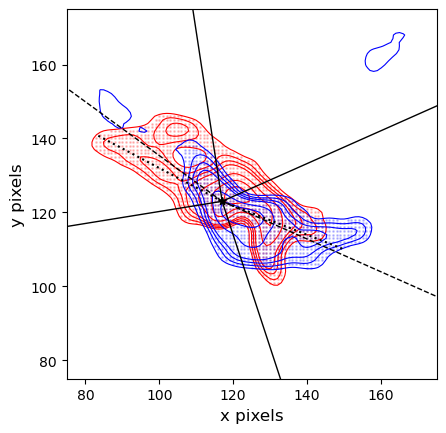

In [147]:
"""    
Same plot, but now with new angles
"""

#Check the masking
fig = plt.figure()
ax = fig.add_subplot(111)

#central protostar
plt.scatter(point1_red[0], point1_red[1], s=30, color='black', zorder=10, marker='*')

#red
plt.scatter(outflow_red_x_masked, outflow_red_y_masked, s=1, color='red', alpha=0.2)
plt.plot([point1_red[0], point2_red[0]], [point1_red[1], point2_red[1]], color='black', zorder=30, linewidth=1.5, linestyle=':')
contourlevels_red=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_red_rms_unsmoothed
contours_red=ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8) #Only place we use unclipped M0 maps

if source_name != 'Oph_29' and source_name != 'Oph_31':
    plt.scatter(outflow_blue_x_masked, outflow_blue_y_masked, s=1, color='blue', alpha=0.2)
    plt.plot([point1_blue[0], point2_blue[0]], [point1_blue[1], point2_blue[1]], color='black', zorder=30, linewidth=1.5, linestyle=':')
    contourlevels_blue=np.array([3,4,5,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54])*B6_blue_rms_unsmoothed
    contours_blue=ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8) #Only place we use unclipped M0 maps
if source_name == 'Oph_26':
    plt.plot([point1_blue[0], new_point2_blue[0]], [point1_blue[1], new_point2_blue[1]], color='black', linestyle='-.', linewidth=1)


# Set the limits for zooming
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_39':
    ax.set_xlim(75,175)
    ax.set_ylim(75,175)

if source_name == 'Oph_27': 
    ax.set_xlim(80,180)
    ax.set_ylim(45,145)

if source_name == 'Oph_29': 
    ax.set_xlim(50,190)
    ax.set_ylim(30,170)

if source_name == 'Oph_31': 
    ax.set_xlim(90,210)
    ax.set_ylim(65,185)

if source_name == 'Oph_34': 
    ax.set_xlim(85,160)
    ax.set_ylim(70,145)

# if source_name == 'Oph_12':
#     ax.set_xlim(80,160)
#     ax.set_ylim(90,160)

# if source_name == 'Oph_26':
#     ax.set_xlim(80,160)
#     ax.set_ylim(90,160)

# if source_name == 'Oph_27':
#     ax.set_xlim(90,145)
#     ax.set_ylim(100,140)

# if source_name == 'Oph_29':
#     ax.set_xlim(75,150)
#     ax.set_ylim(100,155)

# if source_name == 'Oph_31':
#     ax.set_xlim(85,150)
#     ax.set_ylim(90,145)

# if source_name == 'Oph_34':
#     ax.set_xlim(75,160)
#     ax.set_ylim(60,155)

# if source_name == 'Oph_39':
#     ax.set_xlim(90,170)
#     ax.set_ylim(90,160)

plt.xlabel('x pixels')
plt.ylabel('y pixels')
ax.set_aspect('equal')

#Plot the new angles
def rotate_vector(x, y, mu):
    # Calculate the components of the new vector after rotation
    mu = np.radians(mu)
    x_new = x * np.cos(mu) - y * np.sin(mu)
    y_new = x * np.sin(mu) + y * np.cos(mu)
    return np.array([x_new, y_new])

#vector_axis_red is point 2 minus point 1, so assumes point 1 as origin
scaling = 5 #Scaling factor for the new axis, random number, only for plotting
new_axis_red = rotate_vector(vector_axis_red[0], vector_axis_red[1], -mu_red) * scaling #the new vector from fitted mu. Take negative mu because of conventions
new_axis_blue = rotate_vector(vector_axis_blue[0], vector_axis_blue[1], -mu_blue) * scaling 

upper_angle_red = rotate_vector(vector_axis_red[0], vector_axis_red[1], -(mu_red + 0.5*fwqm_red)) * scaling
lower_angle_red = rotate_vector(vector_axis_red[0], vector_axis_red[1], -(mu_red - 0.5*fwqm_red)) * scaling

upper_angle_blue = rotate_vector(vector_axis_blue[0], vector_axis_blue[1], -(mu_blue + 0.5*fwqm_blue)) * scaling
lower_angle_blue = rotate_vector(vector_axis_blue[0], vector_axis_blue[1], -(mu_blue - 0.5*fwqm_blue)) * scaling

if source_name != 'Oph_27':
    plt.plot([point1_red[0], point1_red[0] + new_axis_red[0]], [point1_red[1], point1_red[1] + new_axis_red[1]], color='black', linestyle='--', linewidth=1)
    plt.plot([point1_red[0], point1_red[0] + upper_angle_red[0]], [point1_red[1], point1_red[1] + upper_angle_red[1]], color='black', linestyle='-', linewidth=1)
    plt.plot([point1_red[0], point1_red[0] + lower_angle_red[0]], [point1_red[1], point1_red[1] + lower_angle_red[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_blue[0], point1_blue[0] + new_axis_blue[0]], [point1_blue[1], point1_blue[1] + new_axis_blue[1]], color='black', linestyle='--', linewidth=1)
plt.plot([point1_blue[0], point1_blue[0] + upper_angle_blue[0]], [point1_blue[1], point1_blue[1] + upper_angle_blue[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_blue[0], point1_blue[0] + lower_angle_blue[0]], [point1_blue[1], point1_blue[1] + lower_angle_blue[1]], color='black', linestyle='-', linewidth=1)
plt.savefig(fname=path+'plots/contour+pixels+angles_'+source_name+'_old.png', dpi=300, bbox_inches='tight' )
plt.show()
